<a href="https://colab.research.google.com/github/NzungizeL/scRNA-seq/blob/master/scRNA_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

scRNA-seq (**Single-cell RNA-seq**) allows the detection of gene expression in each cell.

**Preprocessing and clustering**

In [ ]:
#!mkdir data  
#!wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
#!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
#!mkdir write

In [ ]:
#its uninessecary to clone github repo while you donwloaded the data from online database 10X genomics using 'wget'
#!git clone https://github.com/NzungizeL/scRNA-seq.git

In [ ]:
#extract the files from the tar archiver from the directory data
!tar -xvf  '/content/data/pbmc3k_filtered_gene_bc_matrices.tar.gz' -C '/content/data'

filtered_gene_bc_matrices/
filtered_gene_bc_matrices/hg19/
filtered_gene_bc_matrices/hg19/matrix.mtx
filtered_gene_bc_matrices/hg19/genes.tsv
filtered_gene_bc_matrices/hg19/barcodes.tsv


In [ ]:
#list of folders
#!ls -al data 

total 7456
drwxr-xr-x 3 root root    4096 Aug 31 03:32 .
drwxr-xr-x 1 root root    4096 Aug 31 03:48 ..
drwxr-xr-x 3 5027 5000    4096 May 26  2016 filtered_gene_bc_matrices
-rw-r--r-- 1 root root 7621991 Jun  2  2017 pbmc3k_filtered_gene_bc_matrices.tar.gz


In [ ]:
#!pip install scanpy

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc

In [ ]:
# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3             
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.18.5 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.2.post1 statsmodels==0.10.2


In [ ]:
# save the file 
results_file = 'write/pbmc3k.h5ad'  

In [ ]:
# the directory with the `.mtx` file
adata = sc.read_10x_mtx(
    '/content/data/filtered_gene_bc_matrices/hg19',  
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

... writing an h5ad cache file to speedup reading next time


In [ ]:
 # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`
adata.var_names_make_unique() 

In [ ]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


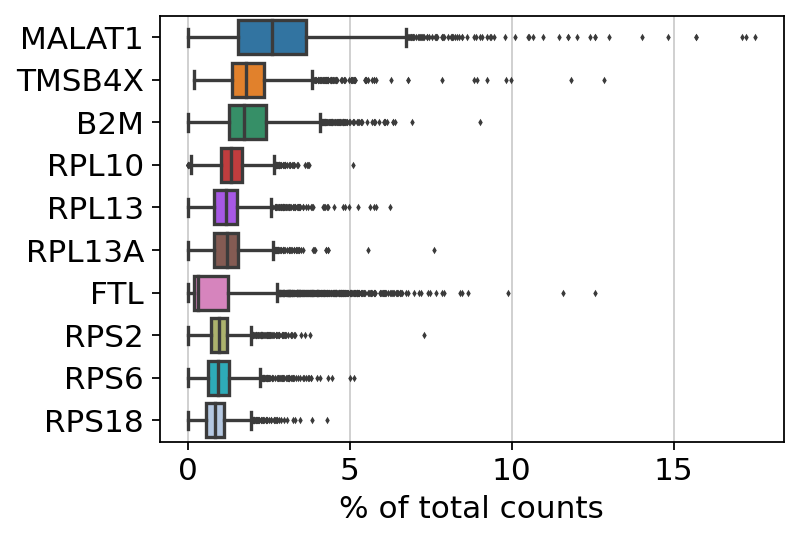

In [ ]:
#Preprocessing 
#visulaize the genes that yield the highest fraction of counts in each single cells, across all cells.
sc.pl.highest_expr_genes(adata, n_top=10, )

In [ ]:
#Basic filtering
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


In [ ]:
# annotate the group of mitochondrial genes as 'mt'
adata.var['mt'] = adata.var_names.str.startswith('MT-')  
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

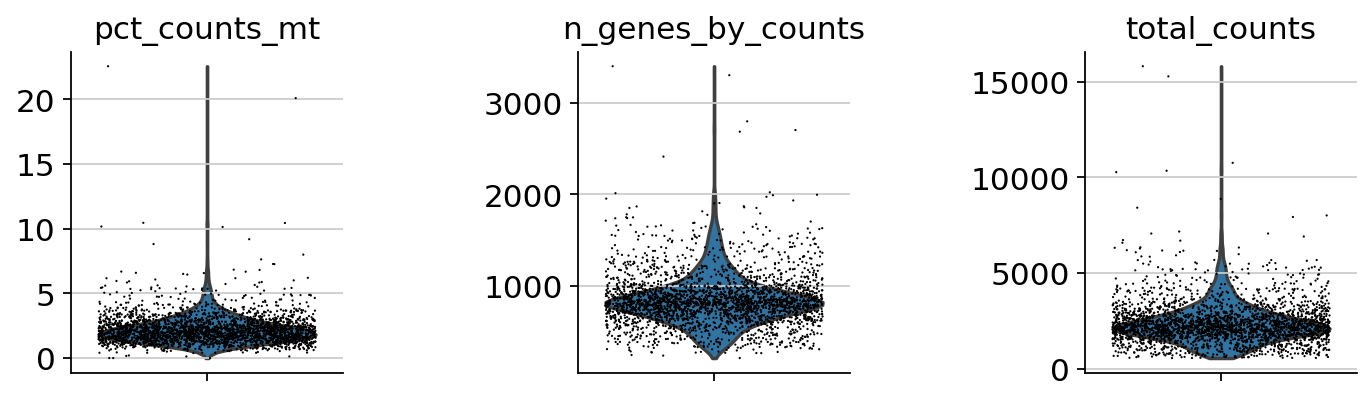

In [ ]:
#violin plot based on computed quality measures
sc.pl.violin(adata, ['pct_counts_mt','n_genes_by_counts', 'total_counts'],
             jitter=0.4, multi_panel=True)

total_counts: total counts per cell,
n_genes_by_counts: number of genes expressed in the count matrix,
pct_counts_mt:percentage of counts in mitochondrial genes.

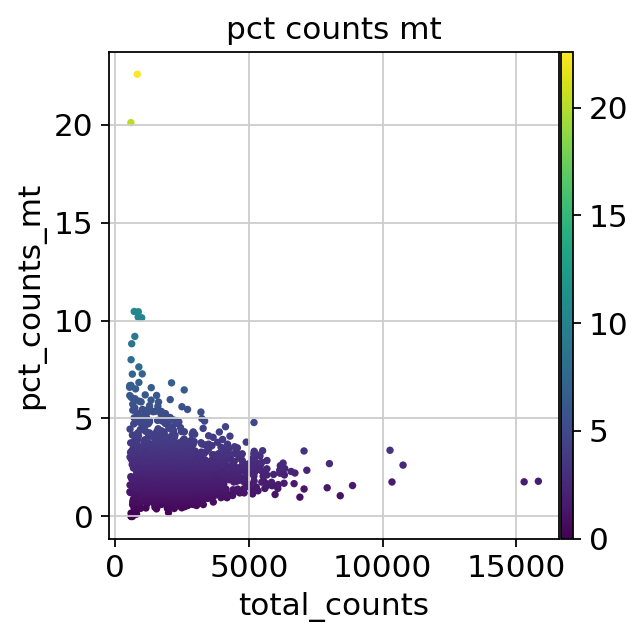

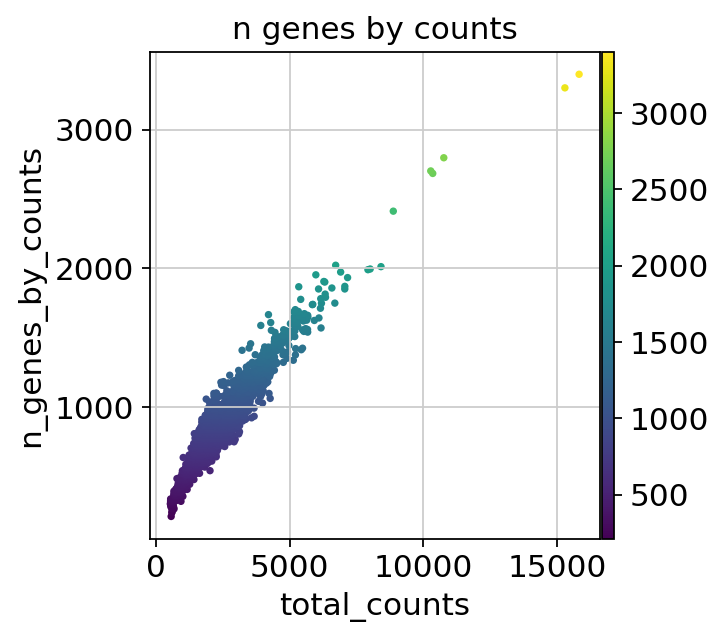

In [ ]:
#Remove cells that have too many mitochondrial genes expressed or too many total counts.
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt',  color='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts',  color='n_genes_by_counts')

In [ ]:
#filtering by slicing the AnnData object.
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

**count normalization** : is essential to make accurate comparisons of gene expression between cells.

In [ ]:
#Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, so that counts become comparable among cells
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [ ]:
#Logarithmize the data.
sc.pp.log1p(adata)

In [ ]:
#Identify highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


**highly variable gene (HVG)** discovery allows the detection of genes that contribute strongly to cell-to-cell variation within a homogeneous cell population (doi: 10.1093/bib/bby011.)

example: Like gene expression, DNA methylation is highly variable at the cell, tissue, and individual level 

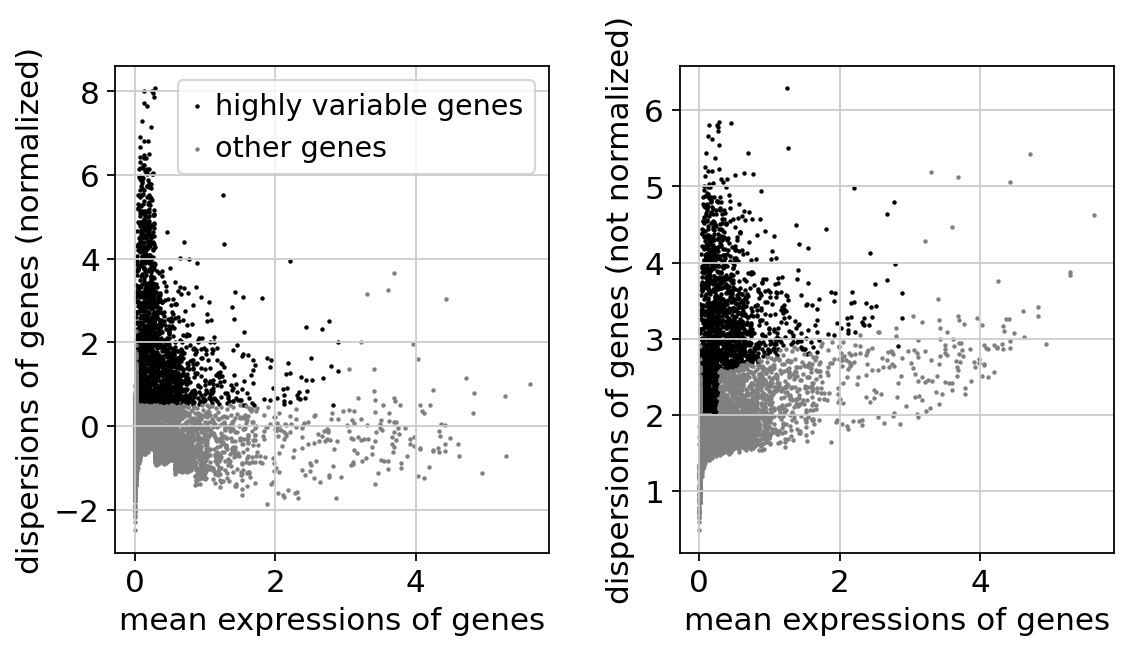

In [ ]:
sc.pl.highly_variable_genes(adata)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


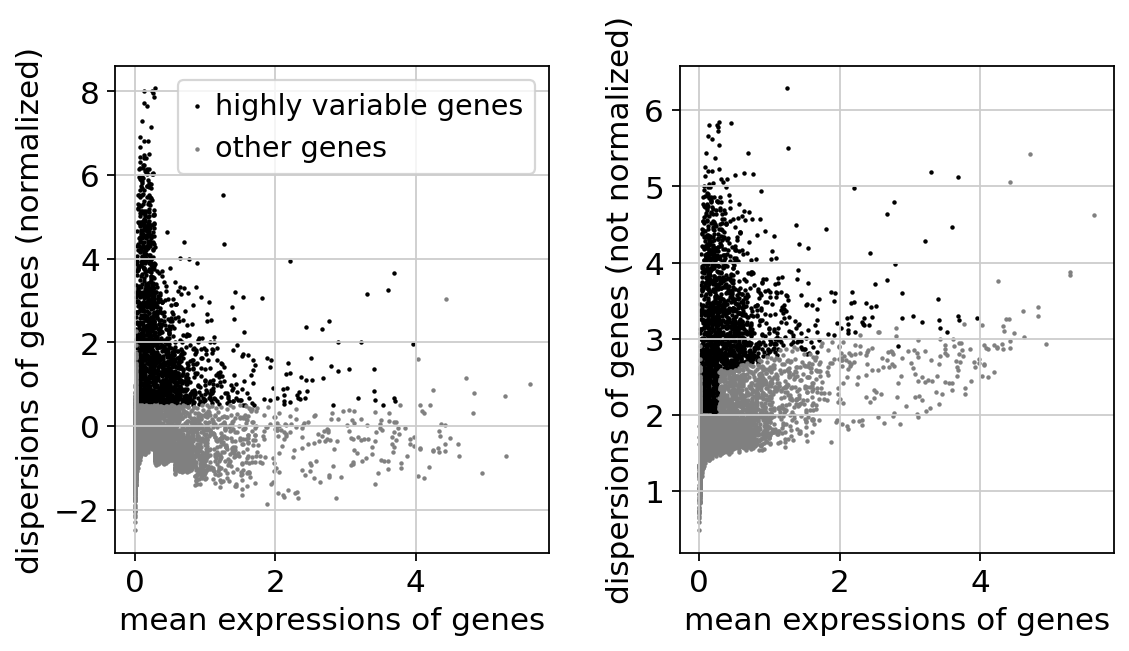

In [ ]:
#Identify highly-variable genes
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=4, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

In [ ]:
#attribute of AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression.
adata.raw = adata

In [ ]:
#filtering
adata = adata[:, adata.var.highly_variable]

In [ ]:
#Scale the data to unit variance.
#Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:00:08)


In [ ]:
#Scale each gene to unit variance and Clip values exceeding standard deviation 10
sc.pp.scale(adata, max_value=10) 

**Principal component analysis PCA**
*   Discovers axes in high-dimensional space that capture the largest amount of variation.

*   PCA is an essential method for analyzing scRNA-seq datasets.

*   PCA used to emphasize variation as well as similarity, and to bring out strong patterns in a dataset (dimensionality reduction).
**Example**:if you measure the expression of 15 genes from 60 mice, and the data come back as a 15×60 table, how do you make sense of all that? How do you even know which mice are similar to one another, and which ones are different? How do you know which genes are responsible for such similarities or differences? ** PCA might be what you need to untangle that data mess**

*   PCs explain the most variation in the dataset






In [ ]:
#Reduce the dimensionality of the data by running principal component analysis (PCA),
# PCA reveals the main axes of variation and denoises the data.
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:00)


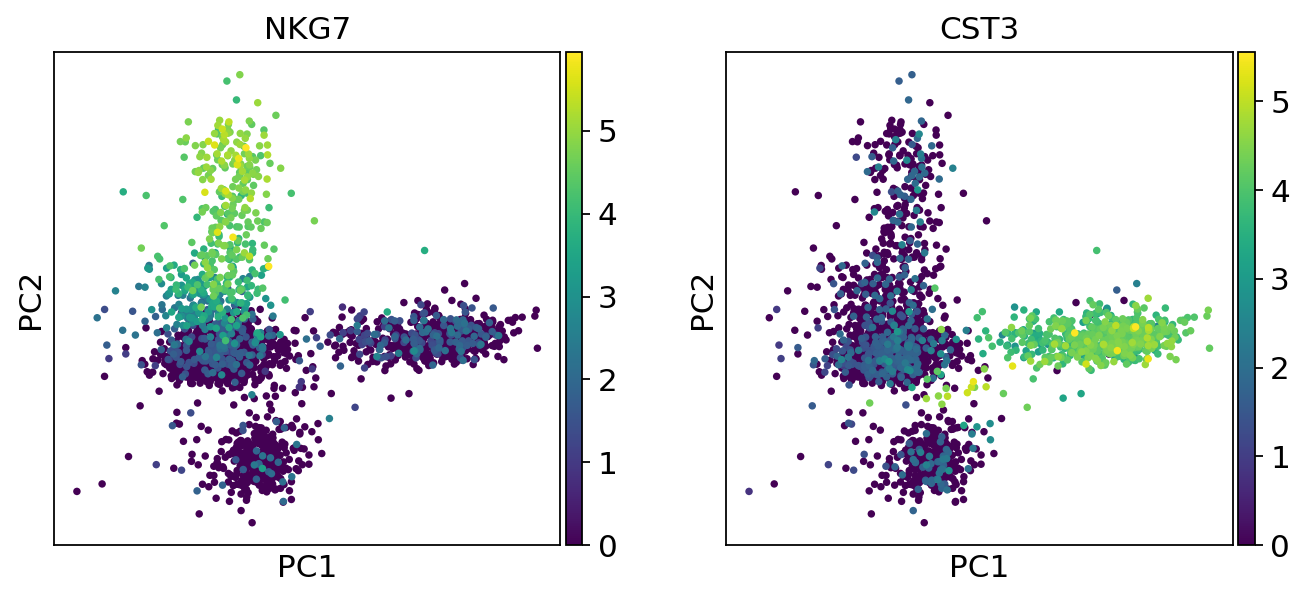

In [ ]:
#scatter plot for PCA
sc.pl.pca(adata, color=['NKG7','CST3'])

In [ ]:
adata.shape

(2638, 1851)

In [ ]:
adata

AnnData object with n_obs × n_vars = 2638 × 1851
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

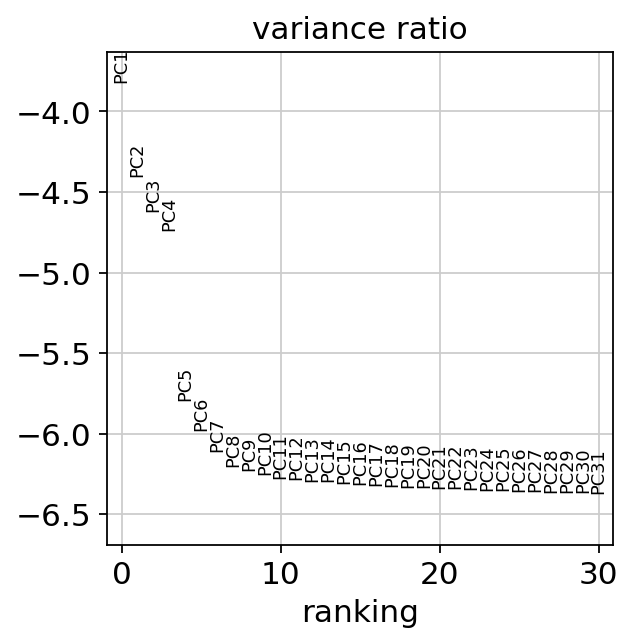

In [ ]:
#The influence of single PCs to the total variance in the data
#acoording to the variance ratio helps us to know how many PCs we should consider in order to compute the neighborhood relations of cells
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
#Save the result.
adata.write(results_file)

In [ ]:
adata

AnnData object with n_obs × n_vars = 2638 × 1851
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

**Computing the neighborhood graph**
Using PCA let us compute the neighborhood graph of cells and
Use default values.

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)


**Neighbor Embedding** :
Its better to embedding the graph in 2 dimensions using UMAP (McInnes et al., 2018)

Addition note
 
*   T-distributed Stochastic Neighbor Embedding (t-SNE) is an unsupervised machine learning algorithm for visualization. t-SNE visualizes local patterns well but distorts global structure, such as distances between clusters.

In [ ]:
sc.tl.umap(adata)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)


**UMAP **(Uniform Manifold Approximation and Projection) 

*   UMAP is a novel manifold learning technique for dimension reduction

*   UMAP is constructed from a theoretical framework based in Riemannian geometry and algebraic topology

*   UMAP algorithm is competitive with t-SNE for visualization quality

Source:  [arXiv:1802.03426](https://arxiv.org/abs/1802.03426)

In [ ]:
#Embedding the neighborhood graph
#tl.paga(adata)
#pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
#tl.umap(adata, init_pos='paga')

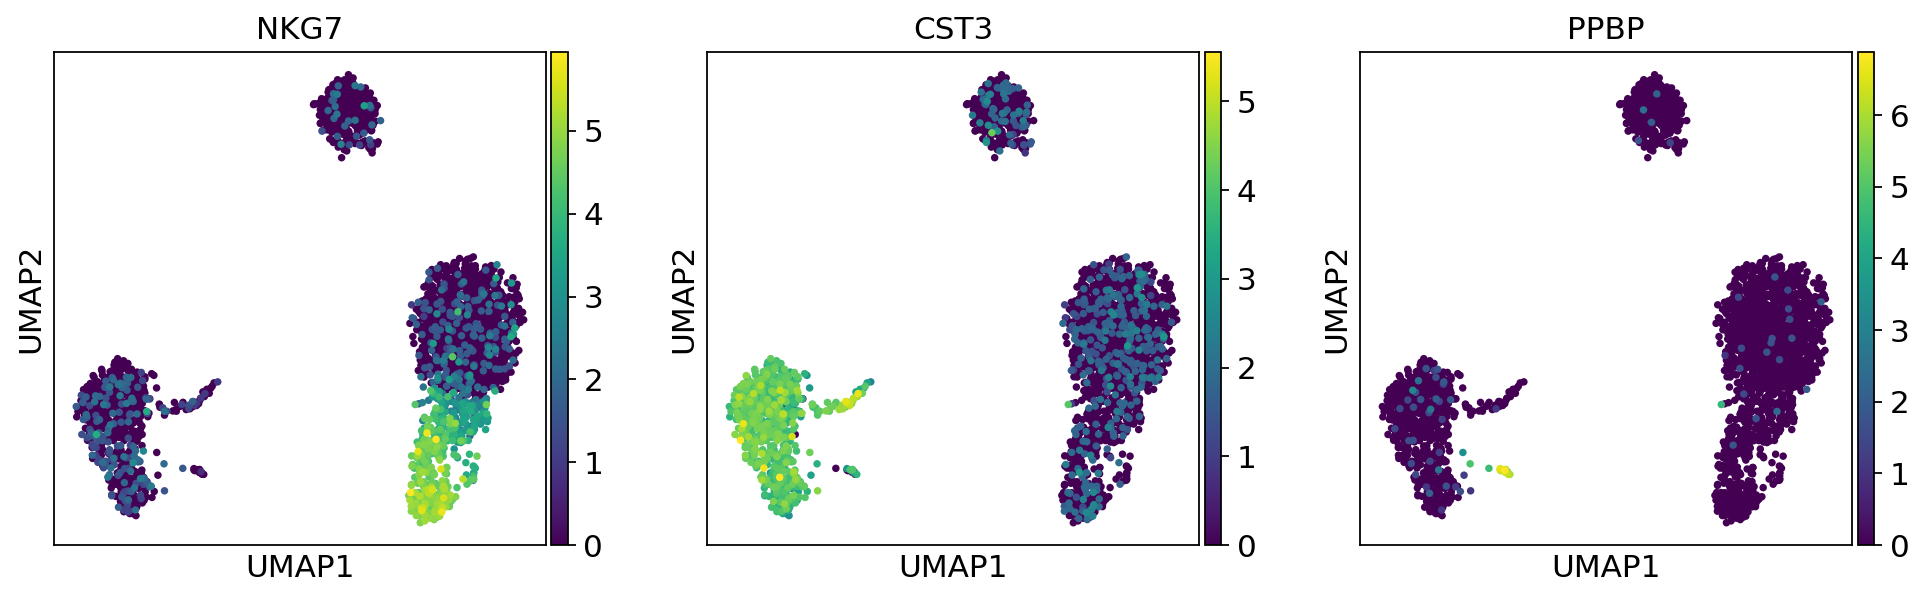

In [ ]:
sc.pl.umap(adata, color=['NKG7','CST3','PPBP'])

**Cytotoxic marker genes**:NKG7, PRF1, GNLY, CD244, GZMB, XCL1 and XCL2 used in Scanpy (Python3) by default.

**TRM markers** CXCR6 and ITGA1. 
Source: [Markers](https://www.ncbi.nlm.nih.gov/gene/3672),       [Marker genes](https://www.nature.com/articles/s41467-019-12464-3)

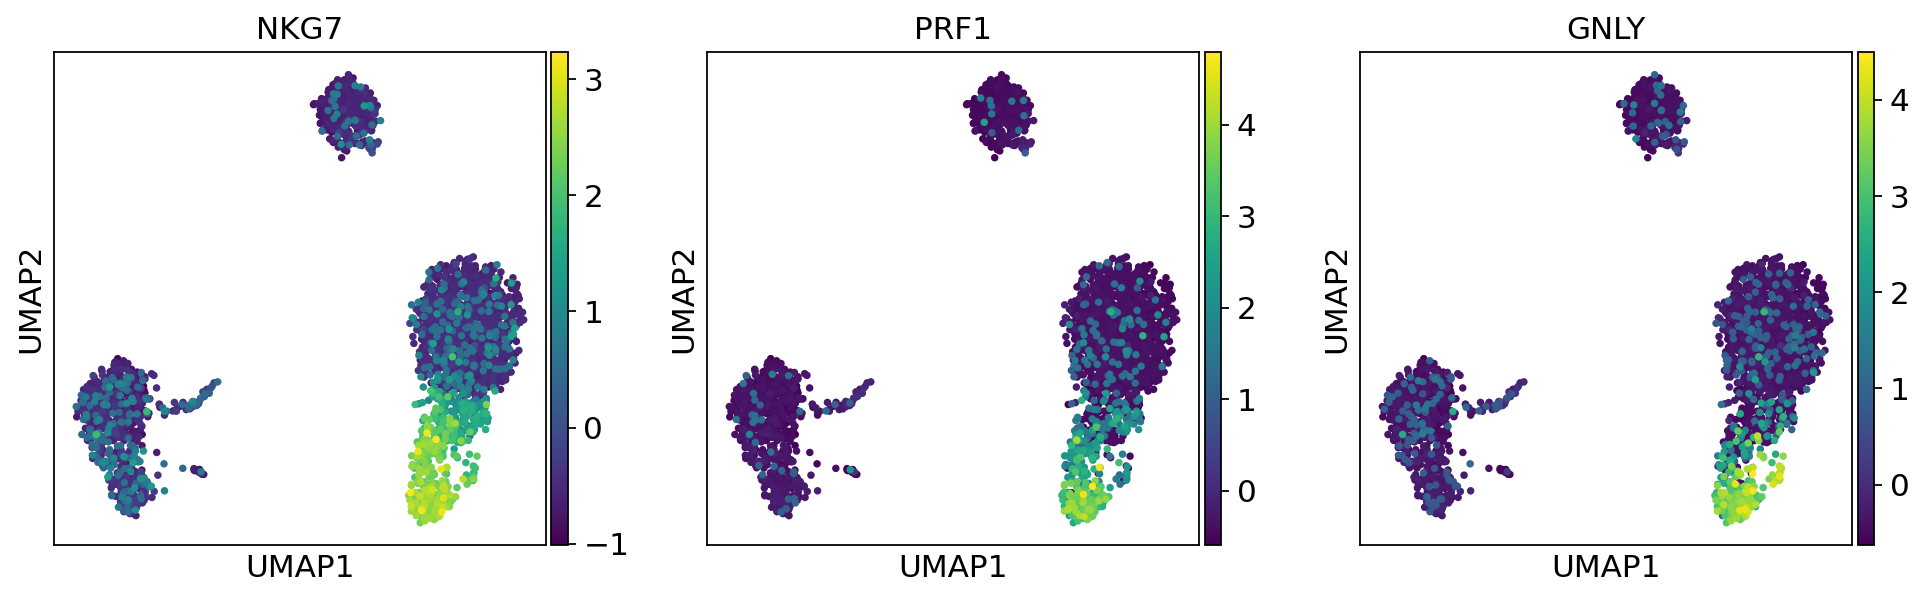

In [ ]:
#plotting the scaled and corrected gene expression by explicitly stating without use .raw 
sc.pl.umap(adata, color=['NKG7','PRF1','GNLY'], use_raw=False) 

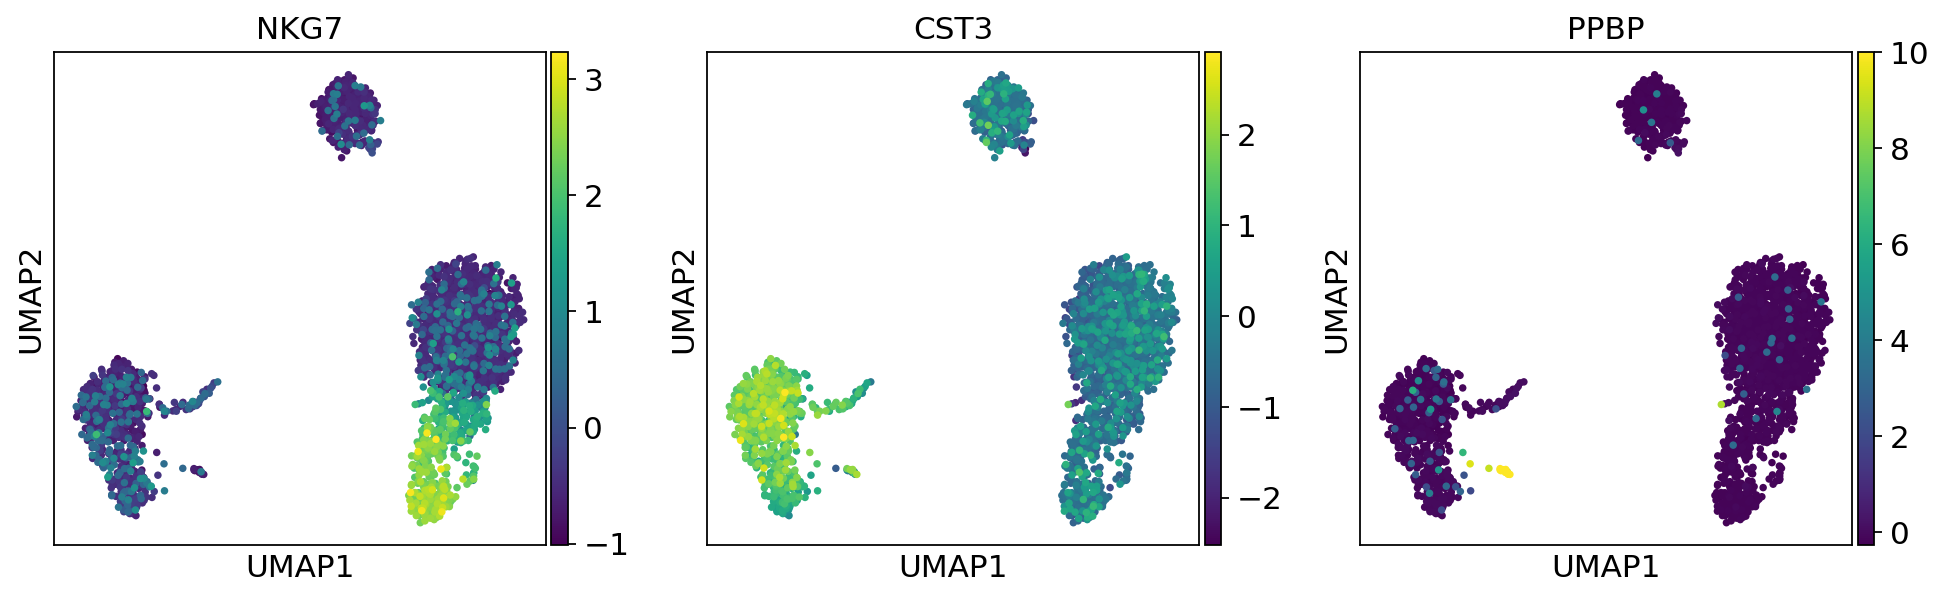

In [ ]:
#plotting the scaled and corrected gene expression by explicitly stating without use .raw 
sc.pl.umap(adata, color=['NKG7','CST3','PPBP'], use_raw=False) 

**Clustering the neighborhood graph**

*   Clustering of scRNA-seq data enables discovering cell subtypes, which is helpful for understanding and analyzing the processes of diseases. 
*   Determining the weight of edges is an essential 

component in graph-based clustering methods are generally based on:
1.   K-nearest neighbor (KNN)
2.   Shared nearest neighbor (SNN)

Source 1. DOI：10.1007/s12539-019-00357-4 [link text]https://pubmed.ncbi.nlm.nih.gov/32086753/)
        2. arXiv:1810.08473[link text](https://arxiv.org/abs/1810.08473)




In [ ]:
#install the leiden algorithm
#!pip install leidenalg

In [ ]:
#Leiden clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.
sc.tl.leiden(adata)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


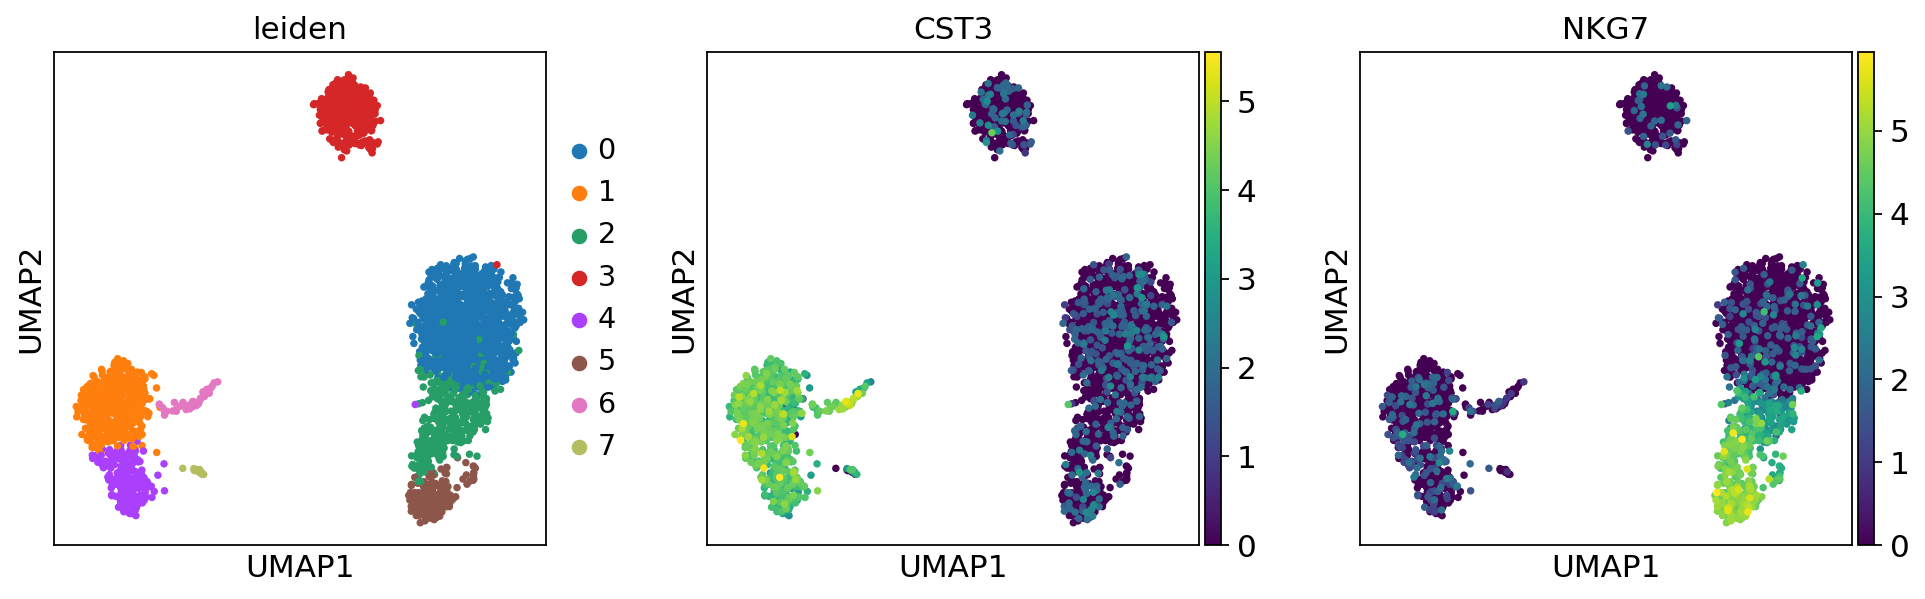

In [ ]:
#Clustering with the Leiden Algorithm 
#Plotting the clusters
sc.pl.umap(adata, color=['leiden', 'CST3', 'NKG7'])



*   **Leiden** is a general algorithm for methods of community detection in large networks.
*   **CST** (Concrete Syntax Tree) parser and serializer library for Python. It’s useful for building automated refactoring (codemod) applications and linters.(CST a popular library for Python is lib 2to 3)



In [ ]:
#Save the result
adata.write(results_file)

**Discovering marker genes in scRNA differential expression ** by computing a highly ranking differential genes in each cluster

ranking genes
    finished (0:00:00)


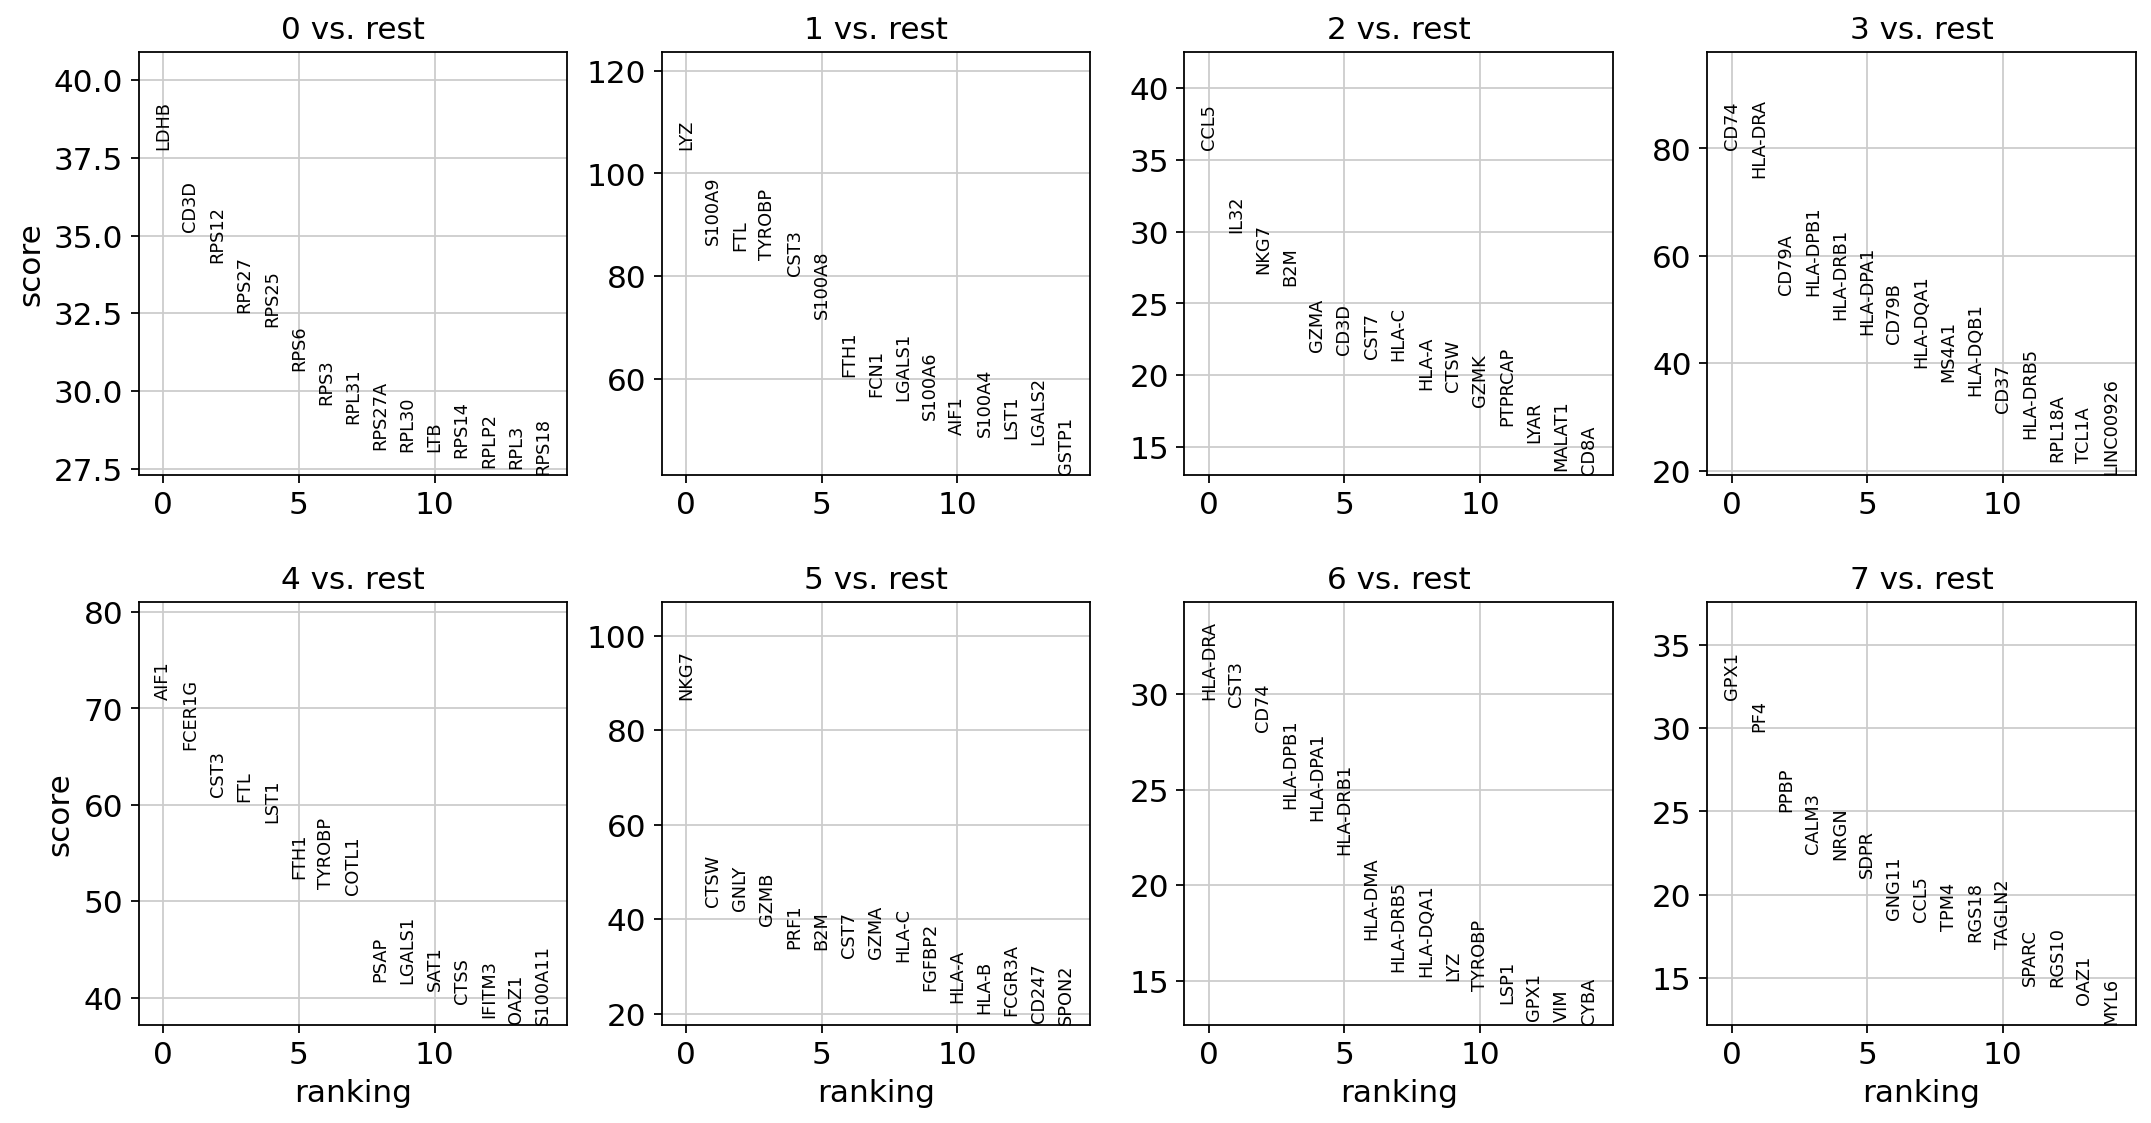

In [ ]:
#Finding marker genes
#by default, use .raw attribute of AnnData in case it has been initialized before. 
#The simplest way and fast is to performe the t-test.
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=15, sharey=False)

In [ ]:
# reduce the verbosity
sc.settings.verbosity = 2  

ranking genes
    finished (0:00:02)


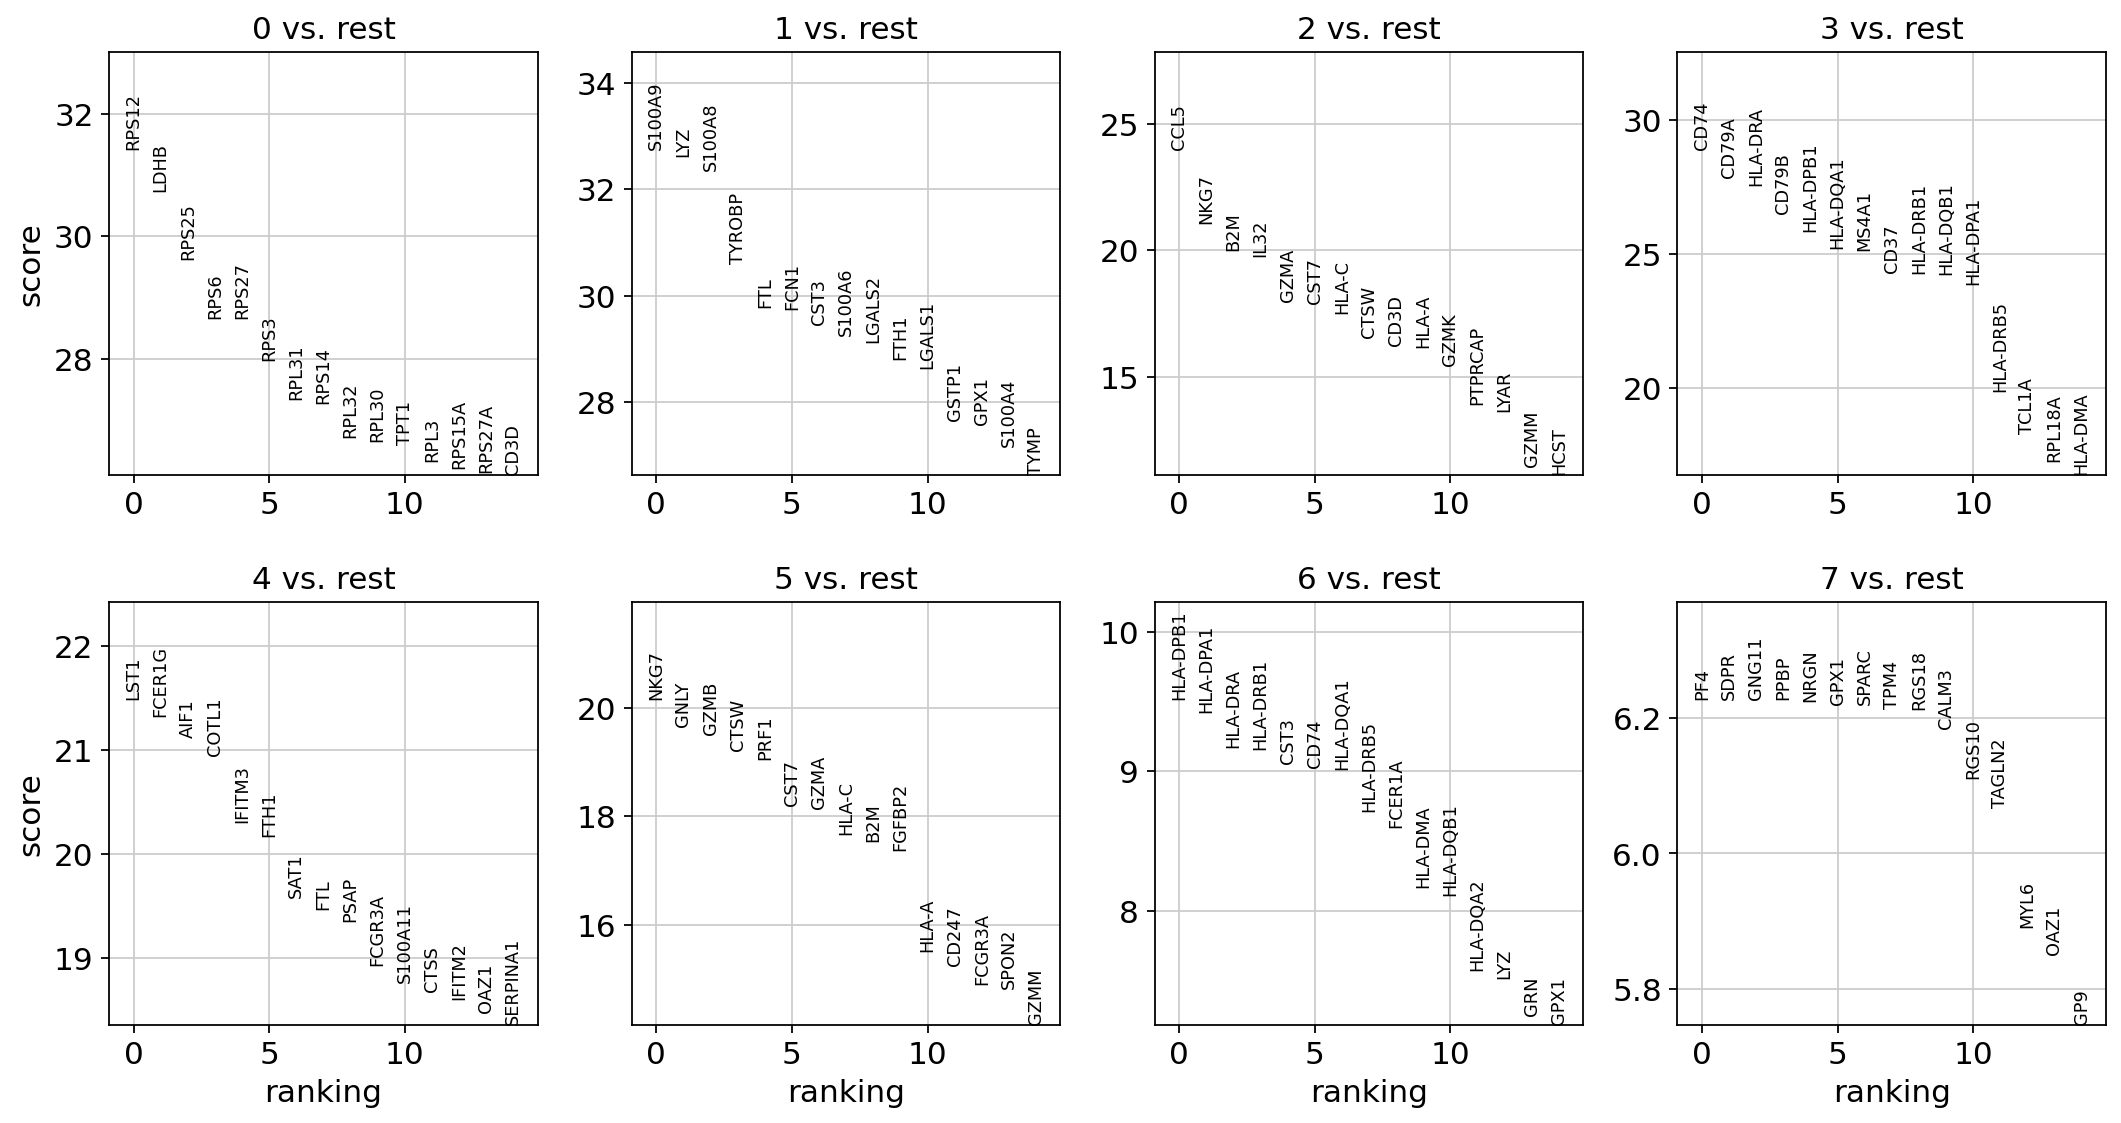

In [ ]:
#check if the results of a Mann-Whitney-U test (Wilcoxon rank-sum) is the to t-test
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=15, sharey=False)

**Note:** The results for both tests are similar

Many methods have been used to determine differential gene expression from single-cell RNA (scRNA)-seq data .(https://doi.org/10.1038/nmeth.4612)

In [ ]:
#Save the result.
adata.write(results_file)

**Logistic Regressionr** : help us to rank the genes 

ranking genes
    finished (0:00:09)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


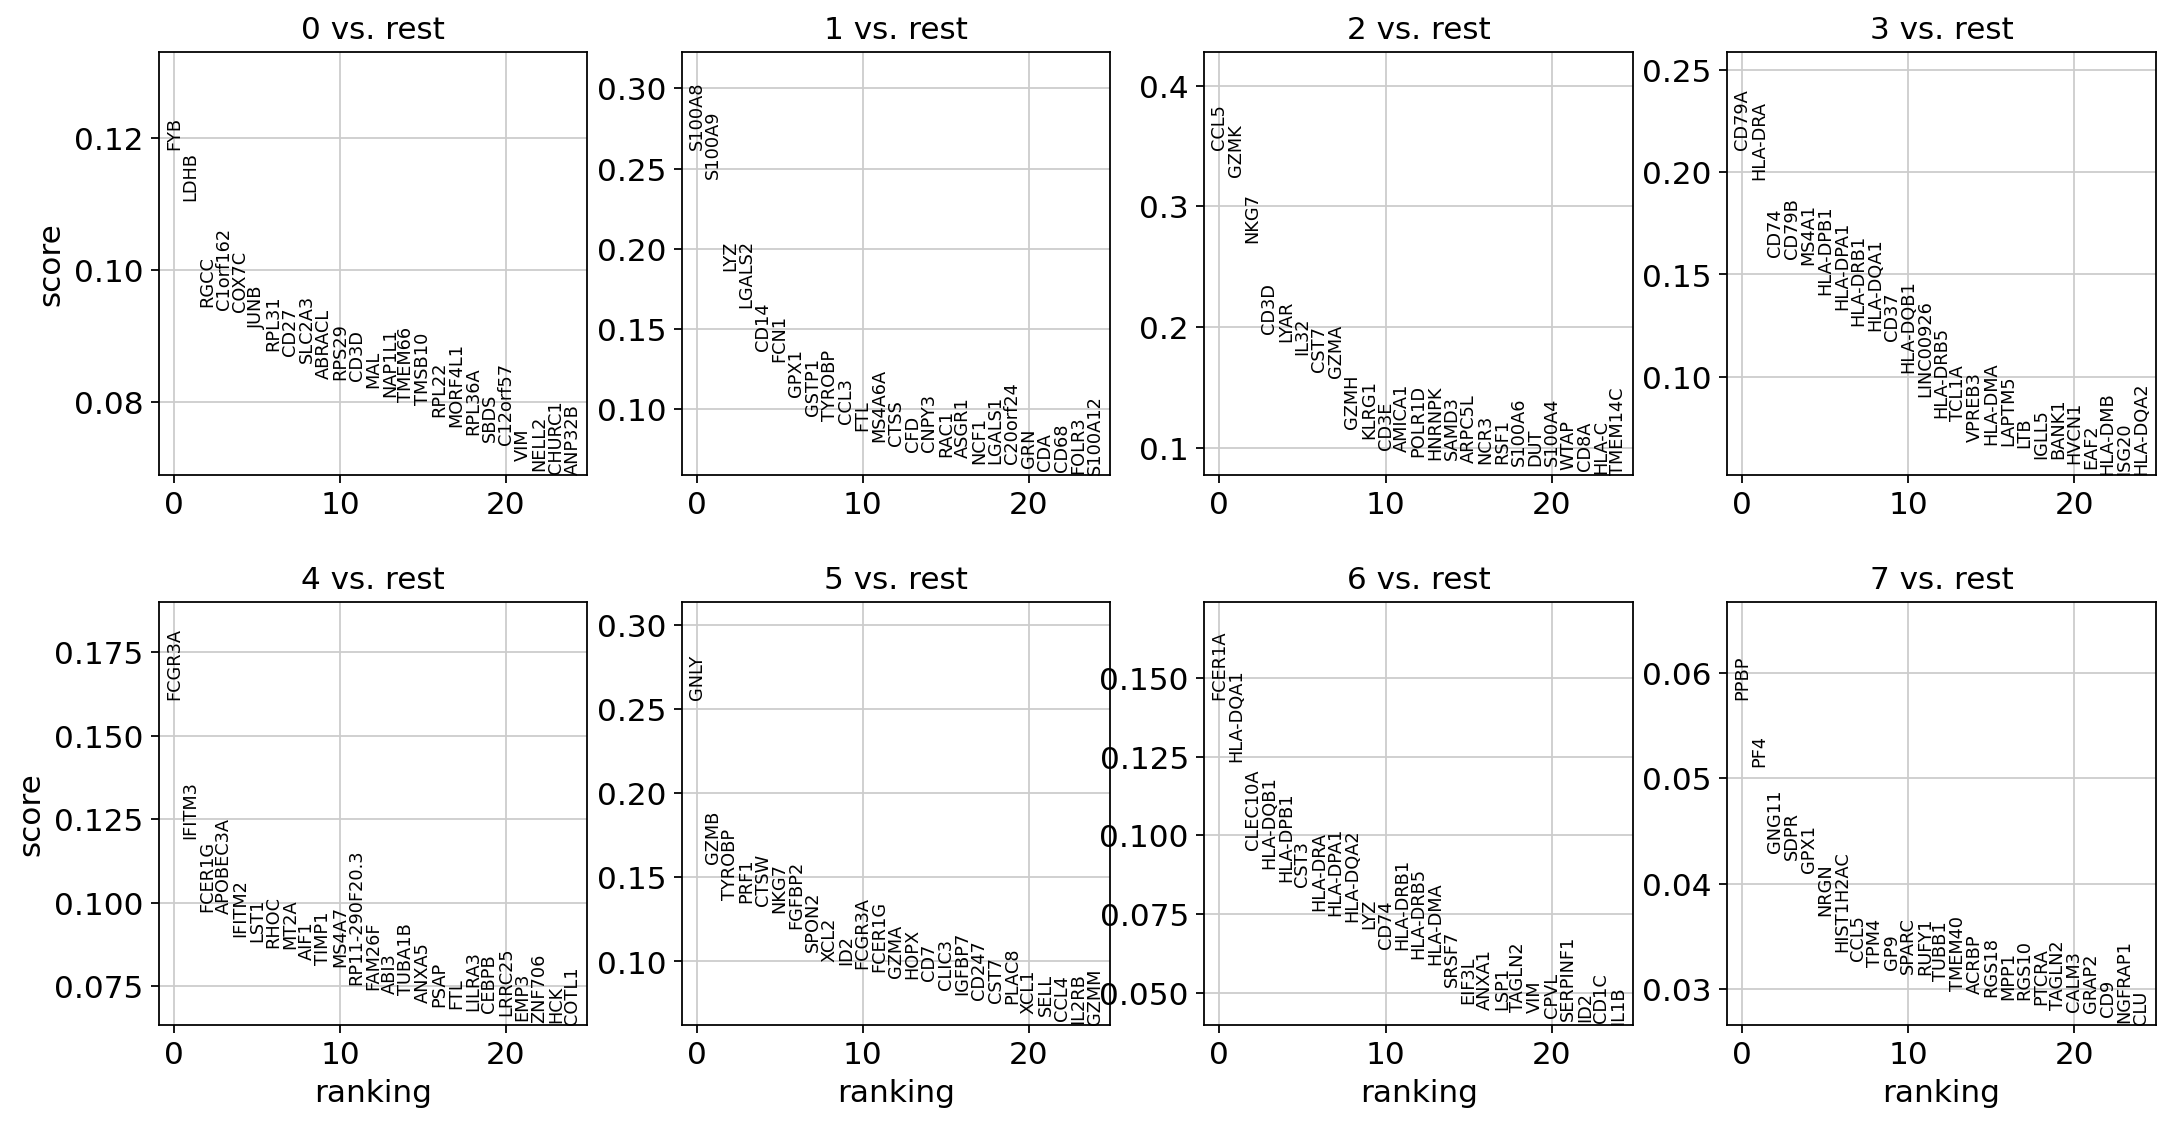

In [ ]:
#conventional differential tests are uni-variate
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

**Gene markers** :'MS4A1', 'CD3E', 'IL7R', 'CCR7', 'CD8A', 'FCGR3A', 'CD14', 'HLA-DRA', "XCL1"
sourcer: [Single Cell Clustering Comparison](https://jef.works/blog/2018/06/28/single-cell-clustering-comparison/)

[Marker Gene](https://www.ebi.ac.uk/gxa/sc/help.html)

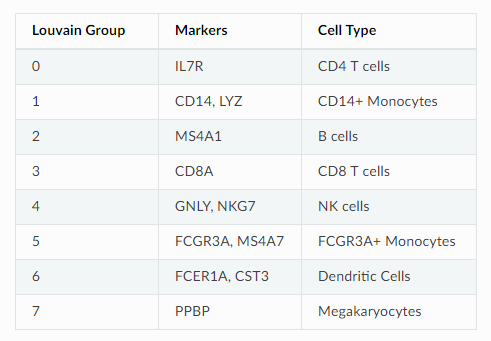

In [ ]:
#define a list of marker genes from the table.
marker_genes = ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14',
                'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1',
                'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']

In [ ]:
#Reload the object that has been save with the Wilcoxon Rank-Sum test result
adata = sc.read(results_file)

In [ ]:
#Identify the 15 top ranked genes for each cluster 0, 1,2,3,4,5,6 and 7 in a dataframe
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(15)

0       1        2         3         4       5         6       7
0    RPS12  S100A9     CCL5      CD74      LST1    NKG7  HLA-DPB1     PF4
1     LDHB     LYZ     NKG7     CD79A    FCER1G    GNLY  HLA-DPA1    SDPR
2    RPS25  S100A8      B2M   HLA-DRA      AIF1    GZMB   HLA-DRA   GNG11
3     RPS6  TYROBP     IL32     CD79B     COTL1    CTSW  HLA-DRB1    PPBP
4    RPS27     FTL     GZMA  HLA-DPB1    IFITM3    PRF1      CST3    NRGN
5     RPS3    FCN1     CST7  HLA-DQA1      FTH1    CST7      CD74    GPX1
6    RPL31    CST3    HLA-C     MS4A1      SAT1    GZMA  HLA-DQA1   SPARC
7    RPS14  S100A6     CTSW      CD37       FTL   HLA-C  HLA-DRB5    TPM4
8    RPL32  LGALS2     CD3D  HLA-DRB1      PSAP     B2M    FCER1A   RGS18
9    RPL30    FTH1    HLA-A  HLA-DQB1    FCGR3A  FGFBP2   HLA-DMA   CALM3
10    TPT1  LGALS1     GZMK  HLA-DPA1   S100A11   HLA-A  HLA-DQB1   RGS10
11    RPL3   GSTP1  PTPRCAP  HLA-DRB5      CTSS   CD247  HLA-DQA2  TAGLN2
12  RPS15A    GPX1     LYAR     TCL1A    IFITM2  FCGR3A       LYZ    MYL6
13  RPS27A  S100A4     GZMM    RPL18A      OAZ1   SPON2       GRN    OAZ1
14    CD3D    TYMP     HCST   HLA-DMA  SERPINA1    GZMM      GPX1     GP9

In [ ]:
#Show in a table with the scores and groups.
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals']}).head(15)

0_n            0_p     1_n  ...           6_p     7_n           7_p
0    RPS12  1.193075e-216  S100A9  ...  1.807106e-21     PF4  4.722886e-10
1     LDHB  1.714016e-207     LYZ  ...  4.442236e-21    SDPR  4.733899e-10
2    RPS25  7.736853e-193  S100A8  ...  4.684930e-20   GNG11  4.733899e-10
3     RPS6  8.407400e-181  TYROBP  ...  5.336773e-20    PPBP  4.744938e-10
4    RPS27  1.203485e-180     FTL  ...  1.334148e-19    NRGN  4.800511e-10
5     RPS3  3.357099e-172    FCN1  ...  1.732222e-19    GPX1  4.947990e-10
6    RPL31  9.693758e-165    CST3  ...  2.018116e-19   SPARC  4.947990e-10
7    RPS14  6.328196e-164  S100A6  ...  3.015651e-18    TPM4  5.159513e-10
8    RPL32  2.244127e-157  LGALS2  ...  8.232408e-18   RGS18  5.195614e-10
9    RPL30  1.309617e-156    FTH1  ...  3.206122e-16   CALM3  6.197000e-10
10    TPT1  4.701611e-156  LGALS1  ...  5.072583e-16   RGS10  9.886323e-10
11    RPL3  8.604844e-153   GSTP1  ...  3.605471e-14  TAGLN2  1.290898e-09
12  RPS15A  1.335754e-151    GPX1  ...  5.849147e-14    MYL6  3.844385e-09
13  RPS27A  8.322342e-151  S100A4  ...  4.254158e-13    OAZ1  4.908800e-09
14    CD3D  2.065126e-150    TYMP  ...  6.800093e-13     GP9  9.078047e-09

[15 rows x 16 columns]

ranking genes
    finished (0:00:01)


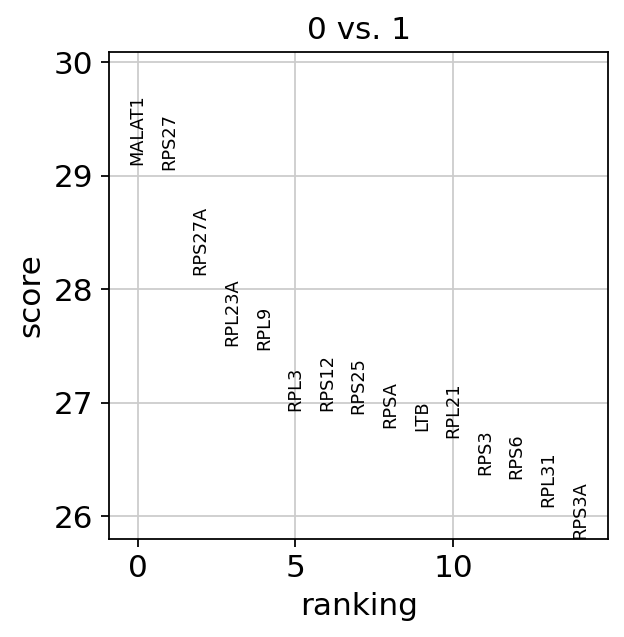

In [ ]:
#Use a single single cluster for comparaison.
sc.tl.rank_genes_groups(adata, 'leiden', groups=['0'], reference='1', method='wilcoxon')
sc.pl.rank_genes_groups(adata, groups=['0'], n_genes=15)

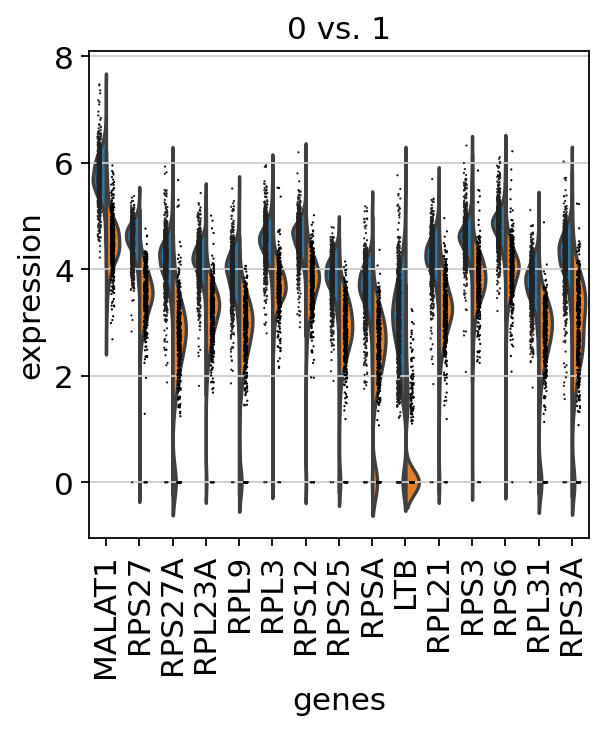

In [ ]:
#represent in violin for more detailed for a certain group
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=15)

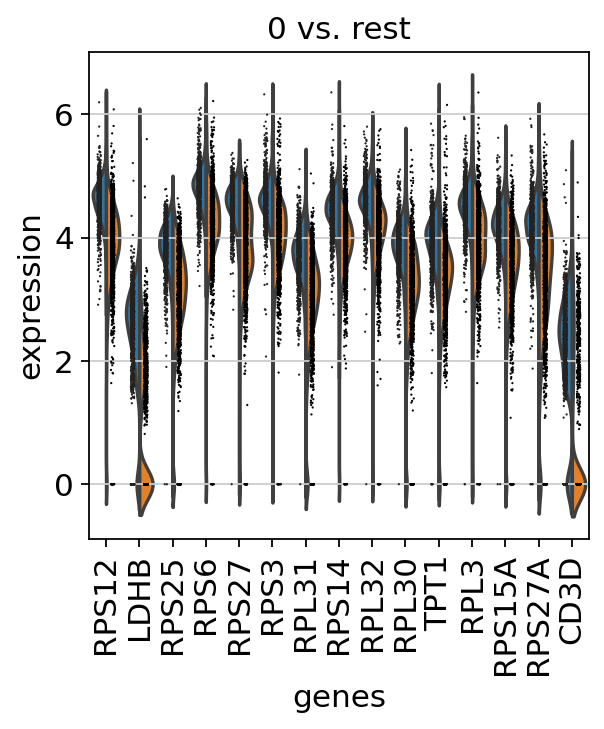

In [ ]:
#Reload the object that computed for differential expression then comparing 0 to the rest of the groups.
adata = sc.read(results_file)
sc.pl.rank_genes_groups_violin(adata, groups='0', n_genes=15)

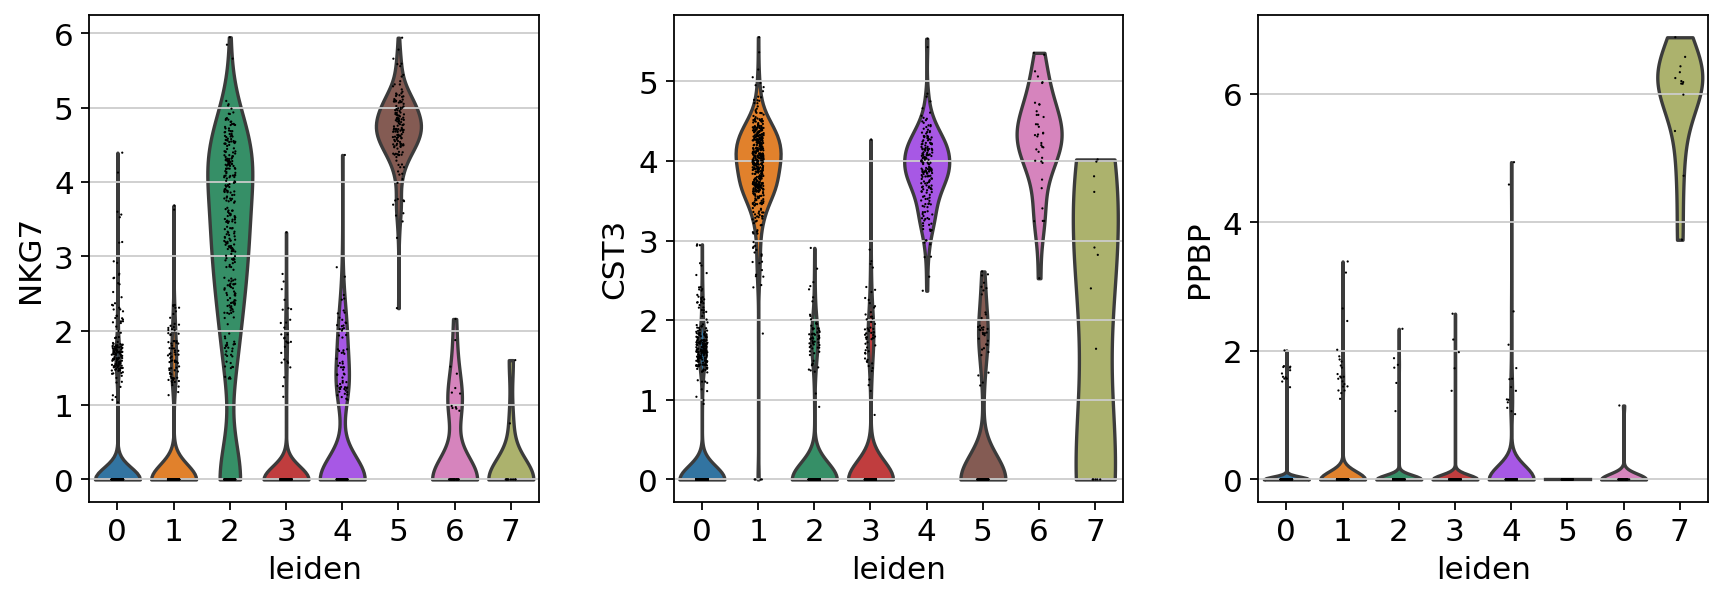

In [ ]:
#compare certain gene across groups
sc.pl.violin(adata, ['NKG7','CST3','PPBP'], groupby='leiden')

In [ ]:
#how to  mark the cell types.
new_cluster_names = [
    'CD4 T', 'CD14 Monocytes',
    'B', 'CD8 T',
    'NK', 'FCGR3A Monocytes',
    'Dendritic', 'Megakaryocytes']
adata.rename_categories('leiden', new_cluster_names)

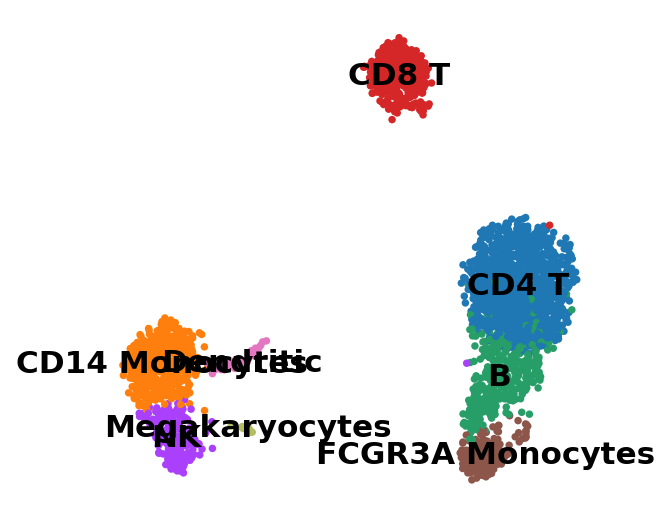

In [ ]:
#mark the cell types
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False, save='.pdf')

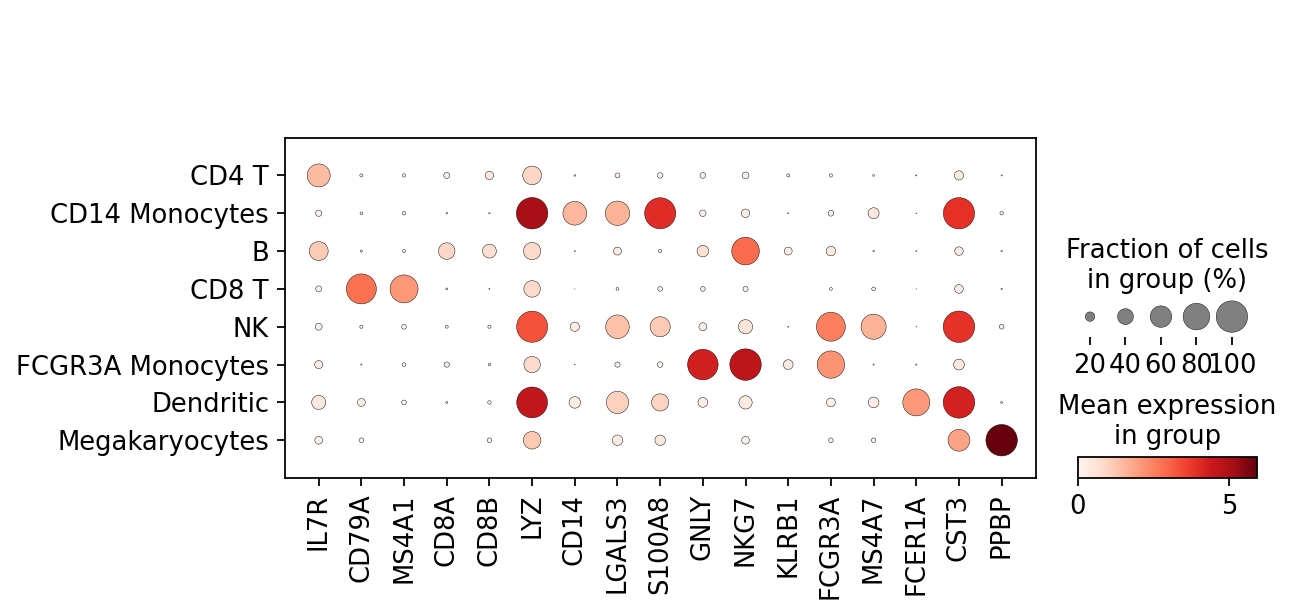

In [ ]:
#visualize the marker genes and annotated the cell types
sc.pl.dotplot(adata, marker_genes, groupby='leiden');

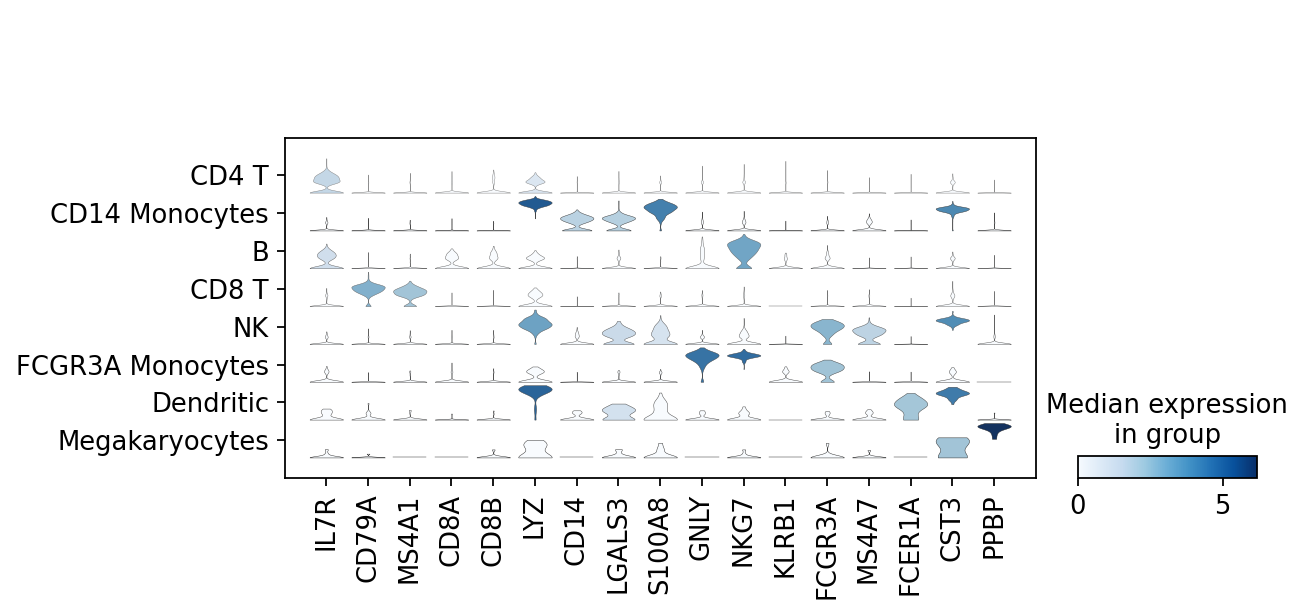

In [ ]:
# you can see similiar figure using violin plot
sc.pl.stacked_violin(adata, marker_genes, groupby='leiden', rotation=90);

In [ ]:
#from the starting AnnData accumlated the following annotations
adata

AnnData object with n_obs × n_vars = 2638 × 1851
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'hvg', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [ ]:
 # `compression='gzip'` saves disk space, but slows down writing and subsequent reading
 adata.write(results_file, compression='gzip')